# __Classifying buildings Post Hurricane using Satellite Imagery__


Team Name: <h2> <i>Crossvalidators</i> </h2><br>
Team Members: <br>
<br>
Geo Abraham (geo4137378@gmail.com)<br>
Puru Sharma (pusharma582000@gmail.com)<br>
Sandeep Dey (1830122@kiit.ac.in)<br>
Rohan Solanke (rohansolanke1702@gmail.com)<br>

## Introduction:

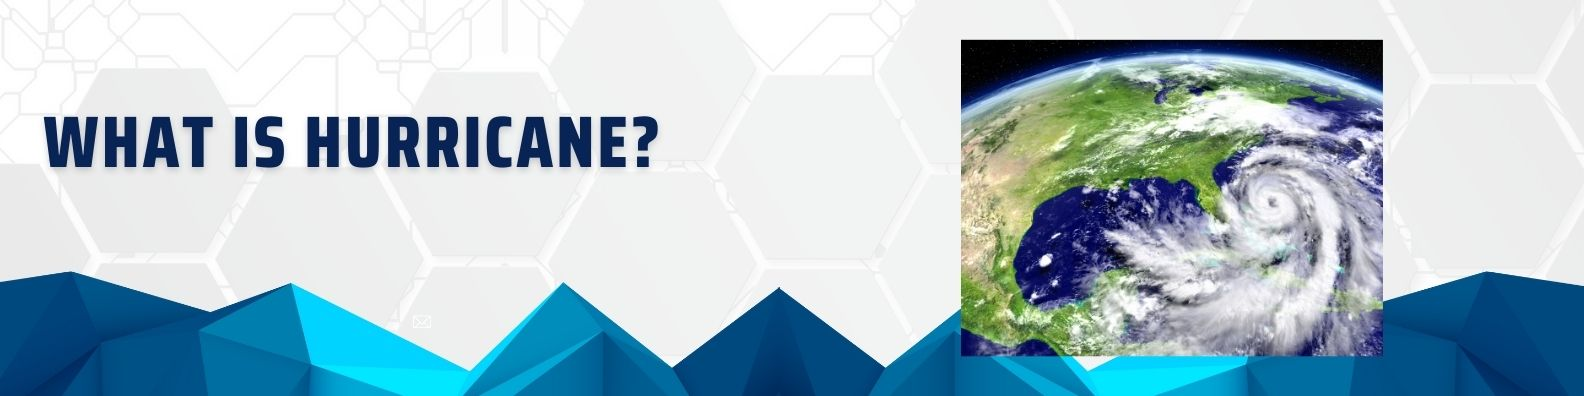

### A hurricane is a tropical storm with winds that have reached a constant speed of 74 miles per hour or more. The eye of a storm is usually 20-30 miles wide and may extend over 400 miles. The dangers of a storm include torrential rains, high winds and storm surges.

## Problem Statement :<br>
### We have to identify if the particular house is damaged or not using Satellite Imagery provided. <br>

## Steps to take : <br>
<b>Step A</b>: Taking a look at the data and images.<br>
<b>Step B</b>: Data pre-processing.<br>
<b>Step C</b>: Building different models using CNN.<br>
<b>Step D</b>: Applying tranfer learning.<br>
<b>Step E</b>: Comaring results and conclusion.<br>

## Step A : Taking a look at the data and images :

In [1]:
#Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import requests
from IPython.core.display import HTML
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import resample
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import glob as gb
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

In [2]:
# Path where images are stored: 
input_path = r'C:\Users\rohan\Desktop\project hurricane'

### Diplaying contents of the data :

In [3]:
# Function to see the files and size of the data:
def print_file_sizes(input_path, subset):
  print('{}:'.format(subset))
  print('')
  path = input_path + subset + '/'
  for f in os.listdir(path):
    if not os.path.isdir(path + f):
      print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
    else:
      sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
      print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
  print('')
    
print_file_sizes(input_path, '/train_another')
print_file_sizes(input_path, '/validation_another')
print_file_sizes(input_path, '/test_another')
print_file_sizes(input_path, '/test')

/train_another:

.DS_Store                     0.01MB
damage                        12.56MB (5000 files)
no_damage                     15.07MB (5000 files)

/validation_another:

damage                        2.52MB (1000 files)
no_damage                     3.02MB (1000 files)

/test_another:

damage                        20.12MB (8000 files)
no_damage                     3.01MB (1000 files)

/test:

.DS_Store                     0.01MB
damage                        2.53MB (1000 files)
no_damage                     2.99MB (1000 files)



### Taking a lok at the Images :

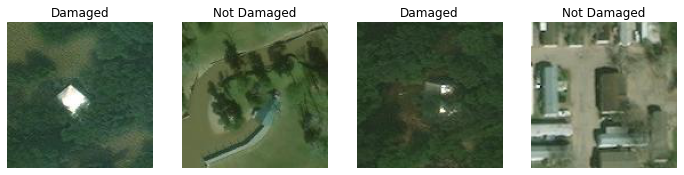

In [12]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
image1=plt.imread(input_path+'/train_another/damage/-93.55964_30.895018.jpeg')
image2=plt.imread(input_path+'/train_another/no_damage/-95.061275_29.831535.jpeg')
image3=plt.imread(input_path+'/test_another/damage/-93.528502_30.987438.jpeg')
image4=plt.imread(input_path+'/train_another/no_damage/-95.2904_29.608598999999998.jpeg')
ax[0].imshow(image1)
ax[0].set_title('Damaged')
ax[0].axis('off')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('Not Damaged')
ax[2].imshow(image3)
ax[2].axis('off')
ax[2].set_title('Damaged')
ax[3].imshow(image4)
ax[3].set_title('Not Damaged')
ax[3].axis('off')
plt.show()

## Step B: Data pre-processing:

In [4]:
train_dir = input_path+'/train_another/'
test_dir = input_path+'/test/'
val_dir=input_path+'/validation_another/'
test_another_dir = input_path+'/test_another/'

In [5]:
size = []
for folder in  os.listdir(train_dir) : 
    files = gb.glob(pathname= str(  train_dir  + folder + '/*.jpeg'))
    print(len(files))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

0
5000
5000


(128, 128, 3)    10000
dtype: int64

In [6]:
(img_width, img_height,img_channel)=size[0]
batch_size = 32
input_dim = (img_width, img_height) + (img_channel,)
classes = ['no_damage', 'damage']
code = {'no_damage':0 ,'damage':1}
code2 = {0:'no_damage' ,1:'damage'}

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        class_names=['no_damage', 'damage'],
      
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        class_names=['no_damage', 'damage'],
       
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        class_names=['no_damage', 'damage'],
        
        image_size=(img_width, img_height),
        batch_size=128,
    )
test_another = tf.keras.preprocessing.image_dataset_from_directory(
        test_another_dir,
        class_names=['no_damage', 'damage'],
        
        image_size=(img_width, img_height),
        batch_size=128,
    )

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


In [8]:
train_data= (train_data.map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, 0.2), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

## Step C: Building different models using CNN.

### Trying simple cnn model:

In [13]:
input_dim

(128, 128, 3)

In [9]:
model_name = "Unregularized CNN"
l_r = 0.001
epochs=15

model_vanilla = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_vanilla.summary())

model_vanilla.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_vanilla = model_vanilla.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        3

In [10]:
model_vanilla.evaluate(test_data)
model_vanilla.evaluate(test_another)

71/71 [==============================] - 9s 120ms/step - loss: 0.0763 - accuracy: 0.9756


[0.0763324648141861, 0.9755555391311646]

In [17]:
img = list(test_data.as_numpy_iterator())

input_img = img[0][0][0]

label = img[0][1][0] 

pred = model_vanilla.predict(tf.ragged.constant(img))

def score_function(predictions):
  # the score should belong to one of the classes of the target variable.
  # use the the output label of the predicted image as shown in the above cell 
  return pred_class
    # return tf.keras.backend.mean((tf.keras.backend.constant(predictions) - tf.keras.backend.constant(label)) **2)


saliency = Saliency(model, clone = False)
saliency_map = saliency(score_function, input_img)

gradcam = Gradcam(model, clone = True)  
cam = gradcam(score_function, input_img)

heatmap = np.uint8(cm.viridis(cam[0])*255)
f, ax = plt.subplots(1, 3)
ax[0].imshow(input_img)
ax[0].set_title("Original")

ax[1].imshow(saliency_map[0], cmap='viridis')
ax[1].set_title("Saliency Map")

ax[2].imshow(input_img)
ax[2].imshow(heatmap, cmap='viridis',alpha = 0.9)
ax[2].set_title("Grad Cam");

ValueError: all scalar values must have the same nesting depth

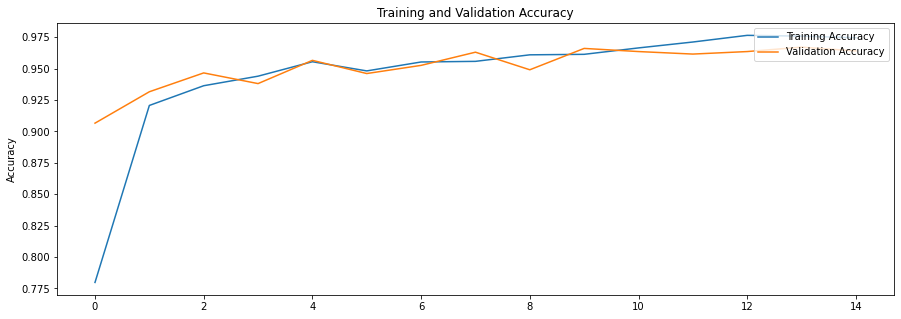

In [29]:
plt.figure(figsize=(15, 5))

plt.plot(history_vanilla.history['accuracy'], label='Training Accuracy')
plt.plot(history_vanilla.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

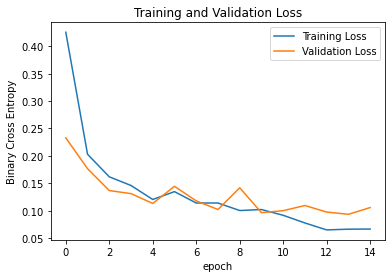

In [30]:
plt.plot(history_vanilla.history['loss'], label='Training Loss')
plt.plot(history_vanilla.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model_vanilla.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|█████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.95it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.99      0.94      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Confusion Matrix
     0    1
0  989   11
1   56  944


### Using normalization techniques:

#### Using Batch Normalization and dropout:

In [64]:
model_name = "cnn batch drop"
l_r = 0.001
epochs=15

model_reg1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  
    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Dropout(0.30),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_reg1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)       

In [65]:
#compile the model 
model_reg1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [67]:
history = model_reg1.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
)

Epoch 1/15
313/313 [==============================] - 66s 163ms/step - loss: 0.7645 - accuracy: 0.8807 - val_loss: 0.8288 - val_accuracy: 0.5085
Epoch 2/15
313/313 [==============================] - 50s 141ms/step - loss: 0.1497 - accuracy: 0.9381 - val_loss: 0.1647 - val_accuracy: 0.9290
Epoch 3/15
313/313 [==============================] - 49s 140ms/step - loss: 0.1420 - accuracy: 0.9475 - val_loss: 1.0305 - val_accuracy: 0.5430
Epoch 4/15
313/313 [==============================] - 49s 140ms/step - loss: 0.1209 - accuracy: 0.9559 - val_loss: 0.2001 - val_accuracy: 0.9290
Epoch 5/15
313/313 [==============================] - 49s 140ms/step - loss: 0.1062 - accuracy: 0.9594 - val_loss: 0.2742 - val_accuracy: 0.8980
Epoch 6/15
313/313 [==============================] - 50s 140ms/step - loss: 0.0897 - accuracy: 0.9680 - val_loss: 0.1681 - val_accuracy: 0.9370
Epoch 7/15
313/313 [==============================] - 50s 140ms/step - loss: 0.0850 - accuracy: 0.9680 - val_loss: 0.3776 - val_ac

In [71]:
model_reg1.evaluate(test_data)
model_reg1.evaluate(test_another)

71/71 [==============================] - 11s 159ms/step - loss: 0.0741 - accuracy: 0.9746


[0.07414203882217407, 0.9745555520057678]

In [73]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_reg1.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|█████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.28it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix
     0    1
0  985   15
1   25  975


#### Applying Early Stopping:

In [74]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True
                                     )

In [75]:
model_name = "Early Stopping"
l_r = 0.001
epochs=15

model_es = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_es.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_es = model_es.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)       

In [77]:
model_es.evaluate(test_data)
model_es.evaluate(test_another)

71/71 [==============================] - 6s 75ms/step - loss: 0.0755 - accuracy: 0.9730


[0.07551365345716476, 0.9729999899864197]

In [76]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_es.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|█████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.84it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix
     0    1
0  985   15
1   25  975


_So far Our best performing model is "model_reg1" with batch Normalization and dropout:_

### Comparing different metrics (using various loss functions, activations):

In [78]:
def add_block(model,num_filter,layer_counts,kernel_size=(3,3),pooling=None,pool_size=None,strides=None):
    for i in range(layer_counts):
        model.add(Conv2D(num_filter,kernel_size,activation="relu",padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(BatchNormalization())
    if pooling:
        model.add(MaxPooling2D(pool_size,strides))

In [85]:
def VGG19_Model(filter_of_first_layer=64):
    model = Sequential()
    model.add.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
    model.add(Input(shape=(128,128,3)))
    add_block(model,filter_of_first_layer,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*2,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*4,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    model.add(Flatten())
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(1,activation="sigmoid"))
    return model

In [80]:
VGG_Model = VGG19_Model()

In [ ]:
VGG_Model.compile(optimizer='sgd',loss=tf.keras.losses.BinaryCrossentropy(),metrics =['accuracy'])
VGG_Model.summary()
EarlyStop=tf.keras.callbacks.EarlyStopping(patience=10)
vgg_history=VGG_Model.fit(train_data,validation_data=val_data,epochs=15,shuffle=True,callbacks=[EarlyStop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                      

## Step D: Applying tranfer learning.

### Applying VGG model:

### Applying ResNet model:

## Step E: Comaring results and conclusion.